<a href="https://colab.research.google.com/github/diegosoaresadv/Modulo-2---TechChalenge/blob/main/TechChalenge2_Modelos_de_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas

In [58]:
!pip install ta

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as plt
import sqlite3 as sql
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Tratamento Inicial dos Dados Brutos

In [60]:
Ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.07.2025,136.743,137.472,137.472,136.014,"9,57M","-0,54%"
1,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
2,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
3,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
...,...,...,...,...,...,...,...
4949,15.07.2005,25.222,25.916,25.916,25.222,"72,88M","-2,69%"
4950,14.07.2005,25.920,25.859,26.142,25.725,"113,35M","0,25%"
4951,13.07.2005,25.856,25.557,26.043,25.557,"107,28M","1,25%"
4952,12.07.2005,25.536,25.027,25.576,24.932,"94,91M","2,08%"


In [61]:
# Tratando as Datas, para podermos trabalhar o modelo com base nos dias
Ibovespa['Data'] = pd.to_datetime(Ibovespa['Data'], format='%d.%m.%Y')
Ibovespa = Ibovespa.sort_values(by='Data', ascending=True).reset_index(drop=True)
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%"
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%"
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%"
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%"
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%"
...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%"
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%"


In [62]:
Ibovespa['Vol.'].unique()

array(['100,42M', '94,91M', '107,28M', ..., '6,12B', '6,75B', '7,58B'],
      dtype=object)

In [63]:
#Criando uma Coluna para separa o Volume -  milhoes e bilhoes - em colunas diferentes. Eu realmente nao sei se o volume é estatisticamente significante para o modelo, entao vale a pena deixar organizado
#Criando as colunas
Ibovespa['Milhoes'] = 0.0
Ibovespa['Bilhoes'] = 0.0
for index, row in Ibovespa.iterrows():
    volume_str = str(row['Vol.'])
    if 'M' in volume_str:
        # Remover 'M', substituir "," por "."", converter em float
        value = float(volume_str.replace('M', '').replace(',', '.'))
        Ibovespa.loc[index, 'Milhoes'] = value
    elif 'B' in volume_str:
        # Remover 'B',  substituir "," por "."", converter em float
        value = float(volume_str.replace('B', '').replace(',', '.'))
        Ibovespa.loc[index, 'Bilhoes'] = value

Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",100.42,0.00
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00
...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58


In [64]:
#Calculando a variação do dia anterior
Ibovespa['Fechamento_Amanha'] = Ibovespa['Último'].shift(1)
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes,Fechamento_Amanha
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",100.42,0.00,NaN
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00,25.016
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00,25.536
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00,25.856
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00,25.920
...,...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31,140.928
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12,141.264
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75,139.490
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58,139.303


In [65]:
#Criando a coluna 'Tendência_Fechamento'
Ibovespa_cleaned = Ibovespa.dropna(subset=['Fechamento_Amanha']).copy()
Ibovespa_cleaned['Tendência_Fechamento'] = (Ibovespa_cleaned['Fechamento_Amanha'] > Ibovespa_cleaned['Último']).astype(int)
Ibovespa = Ibovespa_cleaned
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes,Fechamento_Amanha,Tendência_Fechamento
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00,25.016,0
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00,25.536,0
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00,25.856,0
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00,25.920,1
5,2005-07-18,25.321,25.222,25.412,24.916,"52,17M","0,39%",52.17,0.00,25.222,0
...,...,...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31,140.928,0
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12,141.264,1
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75,139.490,1
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58,139.303,1


In [66]:
#Filtrando apenas as colunas necessarias para ver o que dá
df = (
    Ibovespa
    .rename(columns= {"Máxima": "Maxima", "Mínima": "Minima", "Último": "Fechamento", "Tendência_Fechamento":"Tendencia"})
    .filter(items=['Data','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Milhoes', 'Bilhoes', 'Tendencia'])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4953 entries, 1 to 4953
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        4953 non-null   datetime64[ns]
 1   Fechamento  4953 non-null   float64       
 2   Abertura    4953 non-null   float64       
 3   Maxima      4953 non-null   float64       
 4   Minima      4953 non-null   float64       
 5   Milhoes     4953 non-null   float64       
 6   Bilhoes     4953 non-null   float64       
 7   Tendencia   4953 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 348.3 KB


In [67]:
#Trabalhando a coluna milhoes, multiplicando todas as linhas por 1000000
df['Milhoes'] = df['Milhoes']*1000000
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0


In [68]:
#Trabalhando a coluna bilhoes, multiplicando todas as linhas por 1000000000
df['Bilhoes'] = df['Bilhoes']*1000000000
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0


In [69]:
#Utilizando um join para juntar as colunas, e criando uma unica coluna chamada "Volume"
df['Volume'] = df['Milhoes'] + df['Bilhoes']
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia,Volume
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0,94910000.0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0,107280000.0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0,113350000.0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1,72880000.0
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0,52170000.0


In [70]:
#Excluindo as colunas Milhoes e Bilhoes
df = df.drop(['Milhoes', 'Bilhoes'], axis=1)
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
1,2005-07-12,25.536,25.027,25.576,24.932,0,94910000.0
2,2005-07-13,25.856,25.557,26.043,25.557,0,107280000.0
3,2005-07-14,25.920,25.859,26.142,25.725,0,113350000.0
4,2005-07-15,25.222,25.916,25.916,25.222,1,72880000.0
5,2005-07-18,25.321,25.222,25.412,24.916,0,52170000.0


In [71]:
#Estabelecendo a coluna data como indice
df = df.set_index('Data')
df.head()

,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
Data,,,,,,
2005-07-12,25.536,25.027,25.576,24.932,0,94910000.0
2005-07-13,25.856,25.557,26.043,25.557,0,107280000.0
2005-07-14,25.920,25.859,26.142,25.725,0,113350000.0
2005-07-15,25.222,25.916,25.916,25.222,1,72880000.0
2005-07-18,25.321,25.222,25.412,24.916,0,52170000.0


#Normalzando os Valores de Abertura, Fechamento e Volume

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df[['Fechamento']])
df[['Fechamento']] = scaled_df
scaled_df1 = scaler.fit_transform(df[['Abertura']])
df[['Abertura']] = scaled_df1
scaled_df2 = scaler.fit_transform(df[['Volume']])
df[['Volume']] = scaled_df2
scaled_df3 = scaler.fit_transform(df[['Maxima']])
df[['Maxima']] = scaled_df3
scaled_df4= scaler.fit_transform(df[['Minima']])
df[['Minima']] = scaled_df4
df.tail()
#para retornar os valores ao original utilizar a funcao scaler.inverse_transform(scaleed_df)

,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
Data,,,,,,
2025-07-04,1.000000,0.997114,1.000000,1.000000,0,0.133092
2025-07-07,0.984803,1.000000,0.998097,0.988802,1,0.246080
2025-07-08,0.983201,0.984806,0.983088,0.984286,1,0.271411
2025-07-09,0.967593,0.983196,0.980860,0.971635,1,0.304785
2025-07-10,0.961271,0.967514,0.964925,0.960583,1,0.000385


In [73]:
#Reorganizando a ordem das colunas, para que a coluna Tendencia fique por ultimo
df = df[[ 'Fechamento','Abertura', 'Maxima', 'Minima', 'Volume', 'Tendencia']]
df.head()

,Fechamento,Abertura,Maxima,Minima,Volume,Tendencia
Data,,,,,,
2005-07-12,0.008609,0.004462,0.005803,0.005195,0.003816,0
2005-07-13,0.011351,0.009001,0.009806,0.010570,0.004314,0
2005-07-14,0.011899,0.011588,0.010654,0.012015,0.004558,0
2005-07-15,0.005919,0.012076,0.008717,0.007689,0.002930,1
2005-07-18,0.006768,0.006132,0.004397,0.005057,0.002098,0


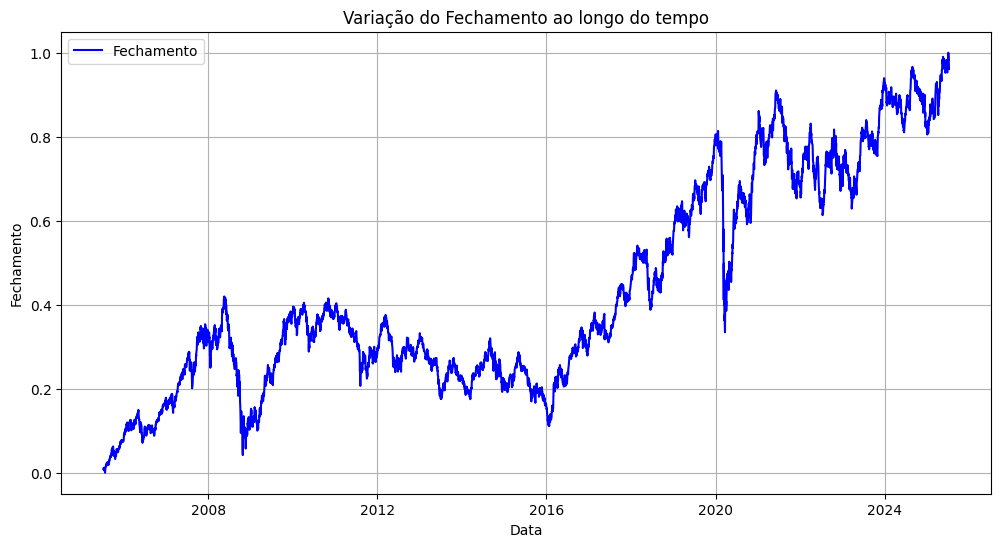

In [74]:
#Plotando o Fechamento no tempo
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Fechamento'], label='Fechamento', color='blue')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title('Variação do Fechamento ao longo do tempo')
plt.legend()
plt.grid(True)
plt.show()


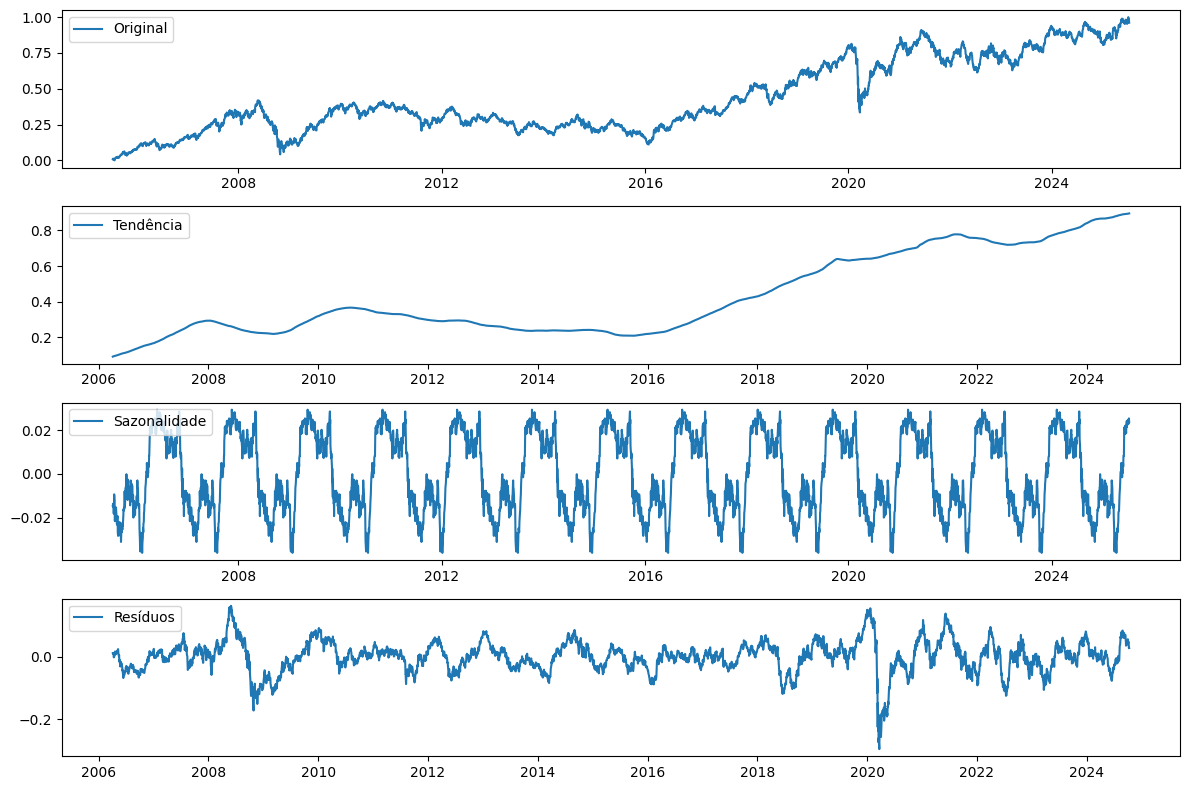

In [75]:
#Retirando a sazonaldiade da série
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Fechamento'], model='additive', period=365)
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df.index, df['Fechamento'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df.index, result.trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df.index, result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(df.index, result.resid, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


# Dividindo o Primeiro Modelo

In [76]:
#Dividindo o Dataset para tratamento
x = df.drop('Tendencia', axis=1)
y = df['Tendencia']
#Identificando a proporção dos processos em que houve pagamento, para identificar o balanceamento
y.value_counts()

,count
Tendencia,
0,2577
1,2376


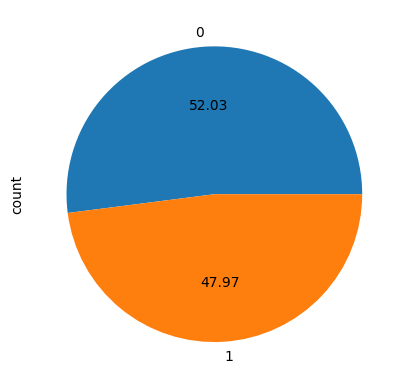

In [77]:
#Plotando um gráfico para ver visualmente a diferença, em termos de proproção
y.value_counts().plot.pie(autopct='%.2f');

- Analisando o nosso dataset, é possível verificar que está próximo ao balanceamento. Com base nessa premissa, vamos iniciar os testes para dar seguimento aos modelos

In [78]:
df_mod1 = df

#Customização do DataSet para verificar a viabildiade deu utilizar Lags, Medias Moveis e outros Features no modelo

# --- Criação das Features ---

In [79]:
# 1. Mudança percentual do fechamento nos últimos N dias
for window in [1, 5, 20]:
    df[f'mudanca_perc_fechamento_{window}d'] = df['Fechamento'].pct_change(periods=window) * 100

# 2. Média móvel do preço de fechamento
for window in [5, 20, 50]:
    df[f'mm_fechamento_{window}d'] = df['Fechamento'].rolling(window=window).mean()

# 3. Volatilidade (desvio padrão dos retornos)
df['retorno_diario'] = df['Fechamento'].pct_change()
for window in [5, 20]:
    df[f'volatilidade_{window}d'] = df['retorno_diario'].rolling(window=window).std()

# 4. Features relacionadas ao Volume de Negociação
for window in [5, 20]:
    df[f'mm_volume_{window}d'] = df['Volume'].rolling(window=window).mean()
    # Evitar divisão por zero se a média móvel do volume for zero
    df[f'volume_vs_mm_volume_{window}d'] = df['Volume'] / df[f'mm_volume_{window}d'].replace(0, 1e-6)

In [80]:
# --- Indicadores Tecnicos ---
import ta

# Mapear os nomes das suas colunas para os nomes esperados pela biblioteca 'ta'
df['high'] = df['Maxima']
df['low'] = df['Minima']
df['close'] = df['Fechamento']
df['volume_ta'] = df['Volume']

df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
macd = ta.trend.MACD(close=df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_diff'] = macd.macd_diff() # Histograma
bollinger = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bollinger_hband'] = bollinger.bollinger_hband()
df['bollinger_lband'] = bollinger.bollinger_lband()
df['bollinger_mavg'] = bollinger.bollinger_mavg()
df['bollinger_pband'] = bollinger.bollinger_pband()
df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume_ta']).on_balance_volume()
stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()
df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()

In [81]:
# 6. Lags dos valores
for lag in [1, 2, 3, 5]:
    df[f'fechamento_lag_{lag}'] = df['Fechamento'].shift(lag)
    df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)
    df[f'retorno_diario_lag_{lag}'] = df['retorno_diario'].shift(lag)

In [82]:
# 7. Features temporais
df['dia_semana'] = df.index.dayofweek # 0=segunda, 6=domingo
df['mes'] = df.index.month
df['ano'] = df.index.year
df['dia_do_ano'] = df.index.dayofyear

In [83]:
# Remover colunas temporárias ou as que não serão usadas como features diretas
df.drop(columns=['Fechamento_Amanha', 'high', 'low', 'close', 'volume_ta', 'retorno_diario'], inplace=True, errors='ignore')

In [84]:
# Remover linhas com valores NaN resultantes da criação das features (especialmente nas primeiras linhas)
df.dropna(inplace=True)

print("\nShape final do DataFrame com todas as features:", df.shape)
print("\nColunas do DataFrame com as novas features:")
print(df.columns.tolist())

print("\nPrimeiras linhas do DataFrame com as features e a variável alvo:")
print(df.head())


Shape final do DataFrame com todas as features: (4904, 46)

Colunas do DataFrame com as novas features:
['Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Tendencia', 'mudanca_perc_fechamento_1d', 'mudanca_perc_fechamento_5d', 'mudanca_perc_fechamento_20d', 'mm_fechamento_5d', 'mm_fechamento_20d', 'mm_fechamento_50d', 'volatilidade_5d', 'volatilidade_20d', 'mm_volume_5d', 'volume_vs_mm_volume_5d', 'mm_volume_20d', 'volume_vs_mm_volume_20d', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'bollinger_hband', 'bollinger_lband', 'bollinger_mavg', 'bollinger_pband', 'obv', 'stoch_k', 'stoch_d', 'atr', 'fechamento_lag_1', 'volume_lag_1', 'retorno_diario_lag_1', 'fechamento_lag_2', 'volume_lag_2', 'retorno_diario_lag_2', 'fechamento_lag_3', 'volume_lag_3', 'retorno_diario_lag_3', 'fechamento_lag_5', 'volume_lag_5', 'retorno_diario_lag_5', 'dia_semana', 'mes', 'ano', 'dia_do_ano']

Primeiras linhas do DataFrame com as features e a variável alvo:
            Fechamento  Abertura    Maxima   

In [85]:
#Analisando a correlação entre as variáveis
df.corr()

,Fechamento,Abertura,Maxima,Minima,Volume,Tendencia,mudanca_perc_fechamento_1d,mudanca_perc_fechamento_5d,mudanca_perc_fechamento_20d,mm_fechamento_5d,...,fechamento_lag_3,volume_lag_3,retorno_diario_lag_3,fechamento_lag_5,volume_lag_5,retorno_diario_lag_5,dia_semana,mes,ano,dia_do_ano
Fechamento,1.000000,0.999235,0.999672,0.999732,0.290370,-0.013580,-0.009562,-0.022320,-0.051855,0.999151,...,0.997879,0.290148,-0.013432,0.996524,0.289682,-0.013057,0.001676,-0.030185,0.870461,-0.030287
Abertura,0.999235,1.000000,0.999687,0.999550,0.289715,0.014128,-0.038959,-0.034724,-0.058535,0.999560,...,0.998570,0.289308,-0.012382,0.997194,0.289131,-0.013538,0.001932,-0.030568,0.870471,-0.030611
Maxima,0.999672,0.999687,1.000000,0.999576,0.289954,-0.000027,-0.023937,-0.030656,-0.058239,0.999505,...,0.998436,0.289509,-0.014122,0.997220,0.288945,-0.014170,0.001691,-0.030069,0.871116,-0.030202
Minima,0.999732,0.999550,0.999576,1.000000,0.290486,-0.002040,-0.021742,-0.024702,-0.051223,0.999218,...,0.997981,0.290329,-0.011706,0.996451,0.289994,-0.011944,0.001417,-0.029986,0.870151,-0.030002
Volume,0.290370,0.289715,0.289954,0.290486,1.000000,-0.006118,0.002228,0.004819,0.005996,0.289230,...,0.288449,0.945032,0.001574,0.287238,0.936481,0.002190,0.011652,-0.131483,0.261726,-0.130966
Tendencia,-0.013580,0.014128,-0.000027,-0.002040,-0.006118,1.000000,-0.588041,-0.253701,-0.128987,0.007836,...,0.013035,-0.011899,0.033515,0.012423,-0.003051,-0.018630,0.009775,-0.007959,0.012959,-0.006254
mudanca_perc_fechamento_1d,-0.009562,-0.038959,-0.023937,-0.021742,0.002228,-0.588041,1.000000,0.348141,0.179256,-0.031842,...,-0.037178,0.003431,-0.081818,-0.035109,0.001237,0.011092,-0.000093,0.004206,-0.024102,0.004609
mudanca_perc_fechamento_5d,-0.022320,-0.034724,-0.030656,-0.024702,0.004819,-0.253701,0.348141,1.000000,0.433041,-0.047075,...,-0.059568,0.006471,0.413447,-0.084786,0.005709,-0.067555,-0.002380,0.003647,-0.053766,0.001292
mudanca_perc_fechamento_20d,-0.051855,-0.058535,-0.058239,-0.051223,0.005996,-0.128987,0.179256,0.433041,1.000000,-0.064992,...,-0.071480,0.007593,0.176176,-0.083797,0.008553,0.158377,-0.000204,-0.005564,-0.117795,-0.004918
mm_fechamento_5d,0.999151,0.999560,0.999505,0.999218,0.289230,0.007836,-0.031842,-0.047075,-0.064992,1.000000,...,0.999559,0.288870,-0.017986,0.998455,0.288524,-0.012836,0.001401,-0.030767,0.870960,-0.030792


In [86]:
#Filtrando as variáveis com maior autocorrelação com a variável fechamento
df.corr()['Fechamento'].sort_values(ascending=False)

,Fechamento
Fechamento,1.000000
Minima,0.999732
Maxima,0.999672
Abertura,0.999235
fechamento_lag_1,0.999232
mm_fechamento_5d,0.999151
fechamento_lag_2,0.998570
fechamento_lag_3,0.997879
fechamento_lag_5,0.996524
bollinger_mavg,0.995486


In [87]:
# Re-create necessary columns that might have been dropped
for lag in [1, 2, 3, 5]:
    df[f'fechamento_lag_{lag}'] = df['Fechamento'].shift(lag)

macd = ta.trend.MACD(close=df['Fechamento'])
bollinger = ta.volatility.BollingerBands(close=df['Fechamento'], window=20, window_dev=2)
df['bollinger_hband'] = bollinger.bollinger_hband()
df['bollinger_lband'] = bollinger.bollinger_lband()
df['bollinger_mavg'] = bollinger.bollinger_mavg()


#Criando um datasete apenas com as variáveis que apresentam maior autocorrelação com a variável fechamento
Ibovespa_df = df[['Fechamento','Tendencia' , 'fechamento_lag_1', 'mm_fechamento_5d', 'fechamento_lag_2', 'fechamento_lag_3', 'fechamento_lag_5', 'mm_fechamento_20d', 'bollinger_mavg', 'bollinger_lband','bollinger_hband' ]]
Ibovespa_df.head()

,Fechamento,Tendencia,fechamento_lag_1,mm_fechamento_5d,fechamento_lag_2,fechamento_lag_3,fechamento_lag_5,mm_fechamento_20d,bollinger_mavg,bollinger_lband,bollinger_hband
Data,,,,,,,,,,,
2005-09-20,0.047356,1,NaN,0.044053,NaN,NaN,NaN,0.033629,NaN,NaN,NaN
2005-09-21,0.054021,0,0.047356,0.047114,NaN,NaN,NaN,0.035371,NaN,NaN,NaN
2005-09-22,0.052659,1,0.054021,0.049362,0.047356,NaN,NaN,0.037070,NaN,NaN,NaN
2005-09-23,0.057936,0,0.052659,0.051894,0.054021,0.047356,NaN,0.038737,NaN,NaN,NaN
2005-09-26,0.056625,1,0.057936,0.053719,0.052659,0.054021,NaN,0.040470,NaN,NaN,NaN


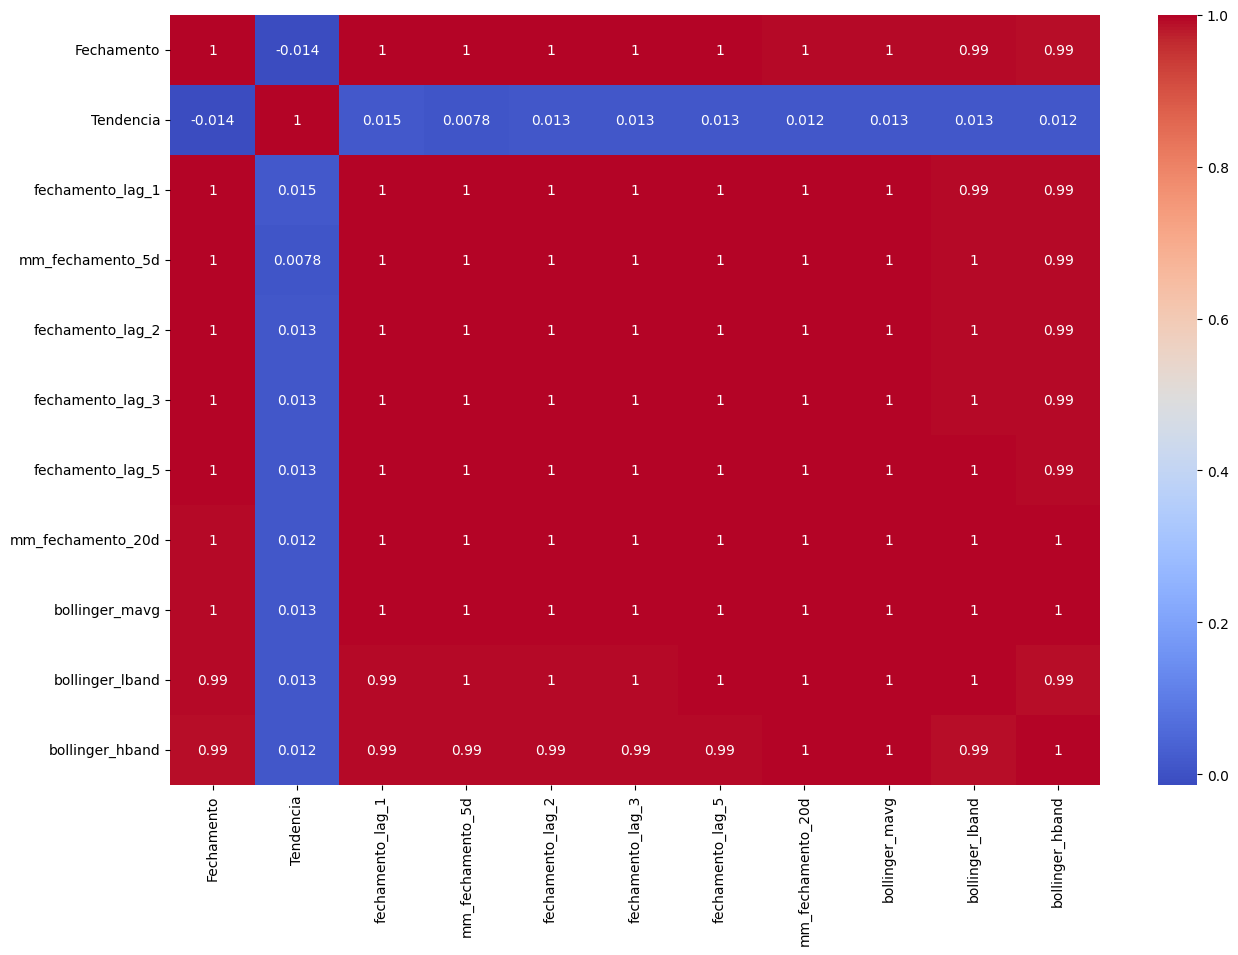

In [88]:
#Criando um mapa de calor para verificar a multicolinearidade entre as variáveis idependentes
plt.figure(figsize=(15,10))
sns.heatmap(Ibovespa_df.corr(), annot=True, cmap='coolwarm')
plt.show()

### Analisando o mapa de calor, podemos verificar uma alta multicoliearidade com a variável bollinger_hband, de modo que se revela um problema para modelos menos robustos. Por isso, vamos retirála.

In [89]:
Ibovespa = Ibovespa_df.drop(['bollinger_hband'], axis=1)
Ibovespa.head()

,Fechamento,Tendencia,fechamento_lag_1,mm_fechamento_5d,fechamento_lag_2,fechamento_lag_3,fechamento_lag_5,mm_fechamento_20d,bollinger_mavg,bollinger_lband
Data,,,,,,,,,,
2005-09-20,0.047356,1,NaN,0.044053,NaN,NaN,NaN,0.033629,NaN,NaN
2005-09-21,0.054021,0,0.047356,0.047114,NaN,NaN,NaN,0.035371,NaN,NaN
2005-09-22,0.052659,1,0.054021,0.049362,0.047356,NaN,NaN,0.037070,NaN,NaN
2005-09-23,0.057936,0,0.052659,0.051894,0.054021,0.047356,NaN,0.038737,NaN,NaN
2005-09-26,0.056625,1,0.057936,0.053719,0.052659,0.054021,NaN,0.040470,NaN,NaN


In [90]:
#Retirando os valores faltantes
Ibovespa = Ibovespa.dropna()
Ibovespa.head()

,Fechamento,Tendencia,fechamento_lag_1,mm_fechamento_5d,fechamento_lag_2,fechamento_lag_3,fechamento_lag_5,mm_fechamento_20d,bollinger_mavg,bollinger_lband
Data,,,,,,,,,,
2005-10-18,0.038866,1,0.048924,0.046121,0.044880,0.045823,0.049223,0.051712,0.051712,0.038812
2005-10-19,0.040828,0,0.038866,0.043864,0.048924,0.044880,0.052110,0.051385,0.051385,0.037752
2005-10-20,0.032664,1,0.040828,0.041233,0.038866,0.048924,0.045823,0.050317,0.050317,0.034505
2005-10-21,0.039792,0,0.032664,0.040215,0.040828,0.038866,0.044880,0.049674,0.049674,0.033260
2005-10-24,0.045437,0,0.039792,0.039518,0.032664,0.040828,0.048924,0.049049,0.049049,0.032993


## Dividindo o Segundo Modelo

In [91]:
#Dividindo o Dataset para tratamento
x2 = Ibovespa.drop('Tendencia', axis=1)
y2 = Ibovespa['Tendencia']
#Identificando a proporção dos processos em que houve pagamento, para identificar o balanceamento, em percentuais
y2.value_counts()/y2.shape[0]*100


,count
Tendencia,
0,51.954964
1,48.045036


#Separando o DataSet em Treino e Teste

In [92]:
#Fazendo o Split de Treino e Teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

##Verificando o balanceamento da base

In [93]:
#Verificando novamente a proporcao
y_train.value_counts()/y_train.shape[0]*100

,count
Tendencia,
0,52.019289
1,47.980711


In [94]:
y_test.value_counts()/y_test.shape[0]*100

,count
Tendencia,
0,52.04893
1,47.95107


- Como esperado, os valores seguem bem semelhantes, de modo que acreditamos que o modelo se encontra razoavelmente balanceado para os testes.

#Criando o Modelo de Regressão Logística

In [95]:
# Criando o Modelo de Regressao Logistica para Teste
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#Criando o Modelo
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# Criando o pipeline com padronização + Regressão Logística
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', random_state=42)
)

# Treinando o modelo
pipeline.fit(x_train, y_train)

# Previsões
y_probs = pipeline.predict_proba(x_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

##Verificando a Performace do Modelo LR - LOGIT

In [96]:
# Prevendo as probabildiades do modelo xtest
y_probs = pipeline.predict(x_test)

# Classificando o modelo
y_pred = (y_probs >= 0.5).astype(int) # Assuming 0.5 as the threshold

# Calculando as Metricas
# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate other metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.94
Accuracy: 0.94
Precision: 1.00
Recall: 0.87
F1 Score: 0.93


##Plotando a Curva ROC

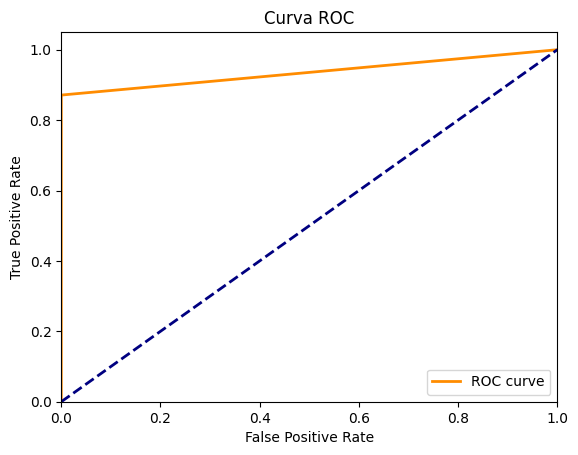

In [97]:
# Fazendo a Plotagem
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

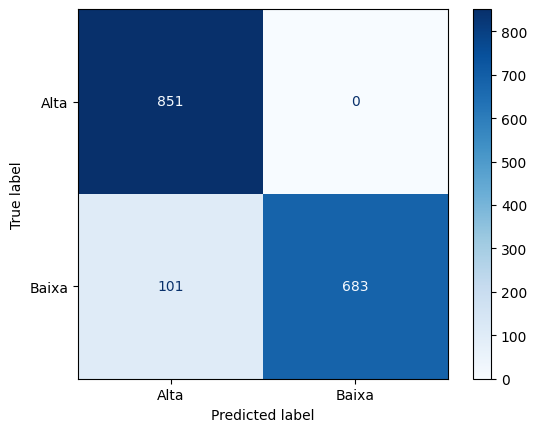

              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94       851
       Baixa       1.00      0.87      0.93       784

    accuracy                           0.94      1635
   macro avg       0.95      0.94      0.94      1635
weighted avg       0.94      0.94      0.94      1635



In [98]:
#Criando a Matriz de Confusao
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
y_pred = (y_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, y_pred, target_names=labels))

#Avaliando as métricas do modelo LR

## Validação Cruzada


--- Avaliação no Conjunto de Teste ---
AUC - ROC Score: 0.94
Accuracy: 0.94
Precision: 1.00
Recall: 0.87
F1 Score: 0.93

--- Avaliação no Conjunto de Treinamento ---
Accuracy (train): 0.93
Precision (train): 1.00
Recall (train): 0.86
F1 Score (train): 0.93

--- Comparação de Overfitting ---
Accuracy Train: 0.93 | Accuracy Test: 0.94

--- Validação Cruzada (F1 Score) ---
F1 Scores por fold: [0.91 0.92 0.91 0.91 0.89]
F1 Score médio: 0.91
Desvio padrão: 0.01


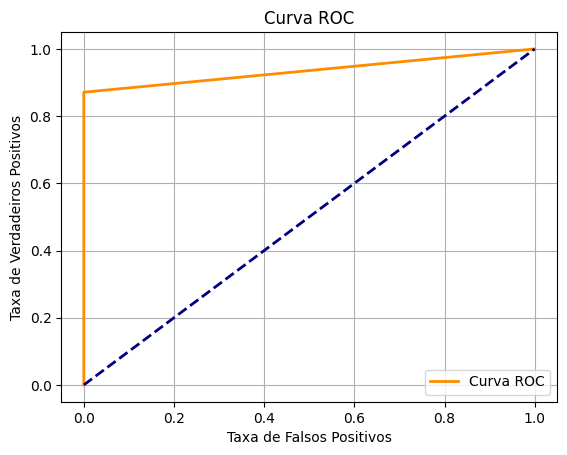

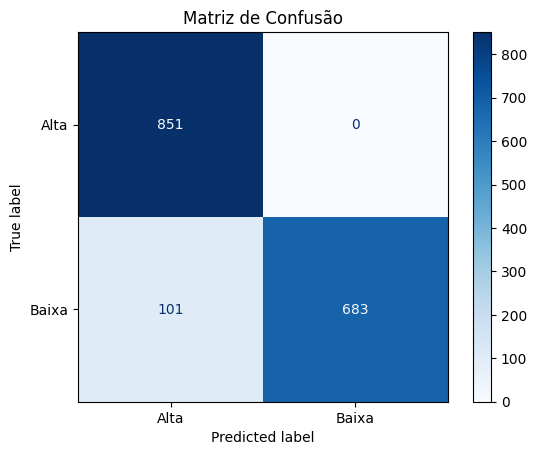


--- Relatório de Classificação ---
              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94       851
       Baixa       1.00      0.87      0.93       784

    accuracy                           0.94      1635
   macro avg       0.95      0.94      0.94      1635
weighted avg       0.94      0.94      0.94      1635



In [99]:
# Importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Métricas no TESTE
print("\n--- Avaliação no Conjunto de Teste ---")
print(f"AUC - ROC Score: {roc_auc_score(y_test, y_probs):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

# Métricas no TREINAMENTO (para overfitting)
y_train_probs = pipeline.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_probs >= 0.5).astype(int)

print("\n--- Avaliação no Conjunto de Treinamento ---")
print(f"Accuracy (train): {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Precision (train): {precision_score(y_train, y_train_pred):.2f}")
print(f"Recall (train): {recall_score(y_train, y_train_pred):.2f}")
print(f"F1 Score (train): {f1_score(y_train, y_train_pred):.2f}")

# Comparação direta
print("\n--- Comparação de Overfitting ---")
print(f"Accuracy Train: {accuracy_score(y_train, y_train_pred):.2f} | Accuracy Test: {accuracy_score(y_test, y_pred):.2f}")

# Validação Cruzada (5-fold com F1 Score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='f1')

print("\n--- Validação Cruzada (F1 Score) ---")
print("F1 Scores por fold:", np.round(cv_scores, 2))
print("F1 Score médio:", np.mean(cv_scores).round(2))
print("Desvio padrão:", np.std(cv_scores).round(2))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=labels))


In [100]:
#Overfiting
# Avaliação do Modelo no Conjunto de Treinamento
y_train_probs = pipeline.predict(x_train)
y_train_pred = (y_train_probs >= 0.5).astype(int)

# Métricas no Treinamento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, zero_division=0)
train_recall = recall_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)

print("\n--- Avaliação no Treinamento ---")
print(f"Accuracy (train): {train_accuracy:.2f}")
print(f"Precision (train): {train_precision:.2f}")
print(f"Recall (train): {train_recall:.2f}")
print(f"F1 Score (train): {train_f1:.2f}")


# Comparar com os valores de teste já calculados anteriormente
print("\n--- Comparação Treinamento vs Teste ---")
print(f"Overfitting? -> Accuracy Train: {train_accuracy:.2f} | Accuracy Test: {accuracy:.2f}")
if train_accuracy - accuracy > 0.10:
    print("⚠️ Indício de Overfitting")
else:
    print("✅ Sem evidência forte de overfitting")


--- Avaliação no Treinamento ---
Accuracy (train): 0.93
Precision (train): 1.00
Recall (train): 0.86
F1 Score (train): 0.93

--- Comparação Treinamento vs Teste ---
Overfitting? -> Accuracy Train: 0.93 | Accuracy Test: 0.94
✅ Sem evidência forte de overfitting


## O modelo foi capaz de prever com precisão a tendência e teve boa performace na análise de overfiting.

# Utilizando outros modelos de classificação


In [101]:
#Importando Bibliotecas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

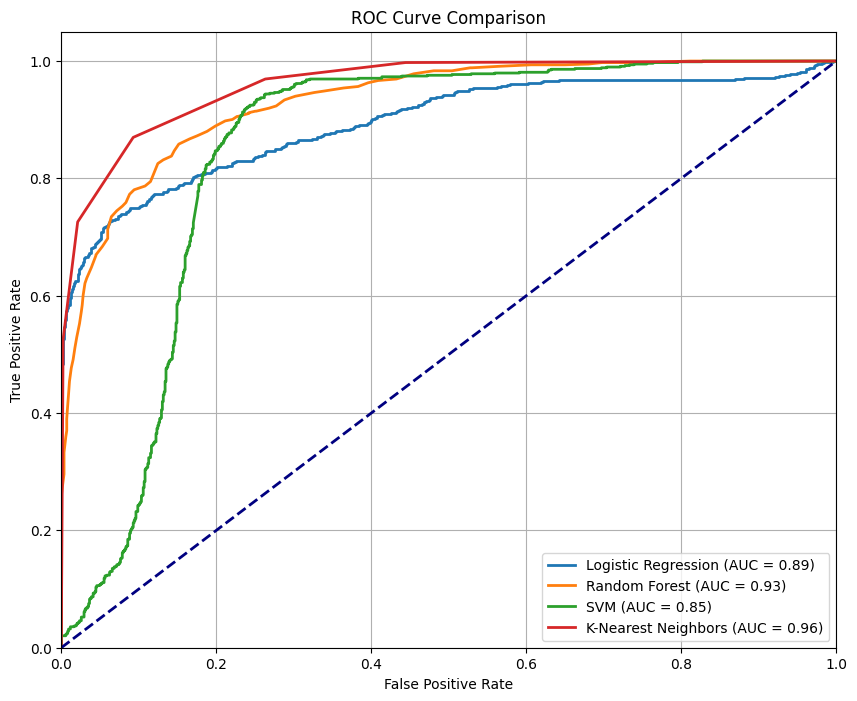


📊 Modelo: Logistic Regression
  - Teste:
    AUC: 0.89
    Accuracy: 0.59
    Precision: 1.00
    Recall: 0.14
    F1: 0.24
  - Treinamento:
    AUC: 0.91
    Accuracy: 0.59
    Precision: 1.00
    Recall: 0.14
    F1: 0.24
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: Random Forest
  - Teste:
    AUC: 0.93
    Accuracy: 0.85
    Precision: 0.85
    Recall: 0.83
    F1: 0.84
  - Treinamento:
    AUC: 1.00
    Accuracy: 1.00
    Precision: 1.00
    Recall: 1.00
    F1: 1.00
  🔍 Overfitting Check (F1): ⚠️ Indício de Overfitting

📊 Modelo: SVM
  - Teste:
    AUC: 0.85
    Accuracy: 0.80
    Precision: 0.80
    Recall: 0.77
    F1: 0.79
  - Treinamento:
    AUC: 0.87
    Accuracy: 0.80
    Precision: 0.81
    Recall: 0.76
    F1: 0.78
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: K-Nearest Neighbors
  - Teste:
    AUC: 0.96
    Accuracy: 0.89
    Precision: 0.90
    Recall: 0.87
    F1: 0.88
  - Treinamento:
    AUC: 0.99
    Acc

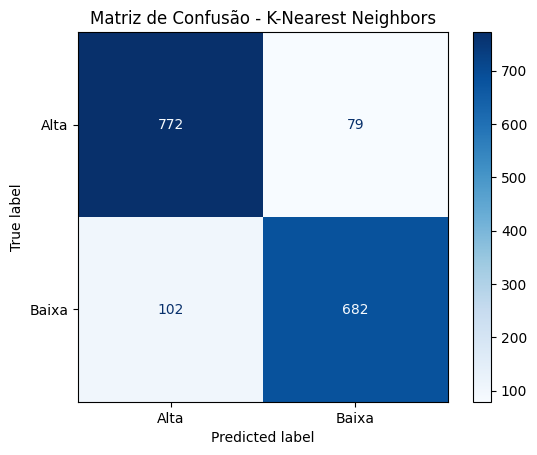

In [102]:
#Definindo os Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
#Criando um Dicionario para os scores
roc_auc_scores = {}
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Dicionários para guardar scores
metrics_train = {}
metrics_test = {}

#Plotando a Curva
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(x_train, y_train)

    # ---- TESTE ----
    y_probs_test = model.predict_proba(x_test)[:, 1]
    y_pred_test = (y_probs_test >= 0.5).astype(int)

    test_metrics = {
        'AUC': roc_auc_score(y_test, y_probs_test),
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1': f1_score(y_test, y_pred_test)
    }

    # ---- TREINAMENTO ----
    y_probs_train = model.predict_proba(x_train)[:, 1]
    y_pred_train = (y_probs_train >= 0.5).astype(int)

    train_metrics = {
        'AUC': roc_auc_score(y_train, y_probs_train),
        'Accuracy': accuracy_score(y_train, y_pred_train),
        'Precision': precision_score(y_train, y_pred_train),
        'Recall': recall_score(y_train, y_pred_train),
        'F1': f1_score(y_train, y_pred_train)
    }

    # Salvando métricas
    metrics_test[name] = test_metrics
    metrics_train[name] = train_metrics

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {test_metrics["AUC"]:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Impressão de métricas
for name in models.keys():
    print(f"\n📊 Modelo: {name}")
    print("  - Teste:")
    for k, v in metrics_test[name].items():
        print(f"    {k}: {v:.2f}")
    print("  - Treinamento:")
    for k, v in metrics_train[name].items():
        print(f"    {k}: {v:.2f}")
    print("  🔍 Overfitting Check (F1):", end=" ")
    train_f1 = metrics_train[name]['F1']
    test_f1 = metrics_test[name]['F1']
    if train_f1 - test_f1 > 0.10:
        print("⚠️ Indício de Overfitting")
    else:
        print("✅ Sem evidência forte de overfitting")

# Matriz de confusão do melhor modelo em termos de F1 Score no teste
best_model_name = max(metrics_test, key=lambda m: metrics_test[m]['F1'])
print(f"\n🏆 Melhor modelo com base no F1 Score de teste: {best_model_name}")

# Reajuste para obter a matriz de confusão
best_model = models[best_model_name]
y_probs_best = best_model.predict_proba(x_test)[:, 1]
y_pred_best = (y_probs_best >= 0.5).astype(int)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.show()

## Analisando os modelos, podemos observar que o modelo KNN obteve melhor performace preditiva, com acuracia de 89%. Contudo, a acurácia desse modelo foi menor do que o primeiro modelo de regressão logística que treinamos. Acreditamos que esse resultado pode ter ocorrido em razão da limitação do número de iterações.

# Verificando o modelo com as Features


### LR

In [103]:
#Fazendo o Split de Treino e Teste
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.33, random_state=42, stratify=y2)

In [104]:
# Criando o Modelo de Regressao Logistica para Teste
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#Criando o Modelo
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# Criando o pipeline com padronização + Regressão Logística
pipeline2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', random_state=42)
)

# Treinando o modelo
pipeline2.fit(x_train2, y_train2)

# Previsões
y_probs2 = pipeline2.predict_proba(x_test2)[:, 1]
y_pred2 = (y_probs2 >= 0.5).astype(int)

In [105]:
# Prevendo as probabildiades do modelo xtest
y_probs2 = pipeline2.predict(x_test2)

# Classificando o modelo
y_pred2 = (y_probs2 >= 0.5).astype(int) # Assuming 0.5 as the threshold

# Calculando as Metricas
# Calculate the AUC - ROC score
roc_auc2 = roc_auc_score(y_test2, y_probs2)

# Calculate other metrics
accuracy2 = accuracy_score(y_test2, y_pred2)
precision2 = precision_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2)
f12 = f1_score(y_test2, y_pred2)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc2:.2f}")
print(f"Accuracy: {accuracy2:.2f}")
print(f"Precision: {precision2:.2f}")
print(f"Recall: {recall2:.2f}")
print(f"F1 Score: {f12:.2f}")

AUC - ROC Score: 0.84
Accuracy: 0.84
Precision: 0.87
Recall: 0.79
F1 Score: 0.83



--- Avaliação no Conjunto de Teste ---
AUC - ROC Score: 0.84
Accuracy: 0.84
Precision: 0.87
Recall: 0.79
F1 Score: 0.83

--- Avaliação no Conjunto de Treinamento ---
Accuracy (train): 0.86
Precision (train): 0.89
Recall (train): 0.80
F1 Score (train): 0.85

--- Comparação de Overfitting ---
Accuracy Train: 0.86 | Accuracy Test: 0.84

--- Validação Cruzada (F1 Score) ---
F1 Scores por fold: [0.81 0.87 0.79 0.86 0.83]
F1 Score médio: 0.83
Desvio padrão: 0.03


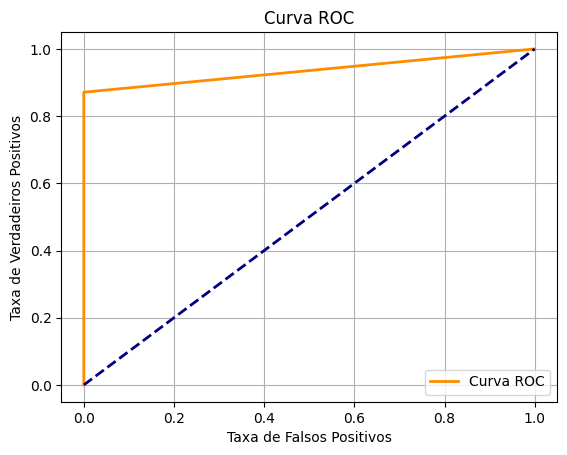

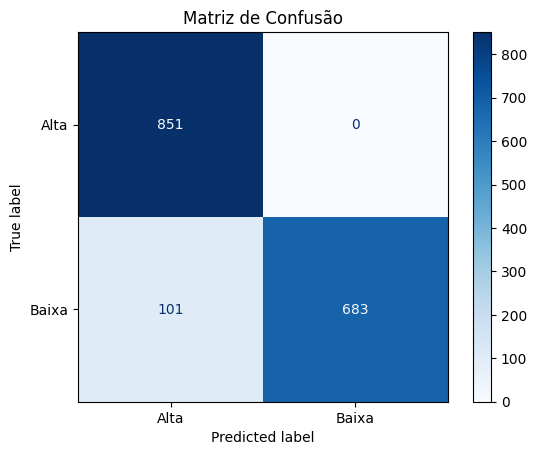


--- Relatório de Classificação ---
              precision    recall  f1-score   support

        Alta       0.82      0.89      0.85       838
       Baixa       0.87      0.79      0.83       775

    accuracy                           0.84      1613
   macro avg       0.85      0.84      0.84      1613
weighted avg       0.84      0.84      0.84      1613



In [106]:
# Importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Métricas no TESTE
print("\n--- Avaliação no Conjunto de Teste ---")
print(f"AUC - ROC Score: {roc_auc_score(y_test2, y_probs2):.2f}")
print(f"Accuracy: {accuracy_score(y_test2, y_pred2):.2f}")
print(f"Precision: {precision_score(y_test2, y_pred2):.2f}")
print(f"Recall: {recall_score(y_test2, y_pred2):.2f}")
print(f"F1 Score: {f1_score(y_test2, y_pred2):.2f}")

# Métricas no TREINAMENTO (para overfitting)
y_train_probs2 = pipeline2.predict_proba(x_train2)[:, 1]
y_train_pred2 = (y_train_probs2 >= 0.5).astype(int)

print("\n--- Avaliação no Conjunto de Treinamento ---")
print(f"Accuracy (train): {accuracy_score(y_train2, y_train_pred2):.2f}")
print(f"Precision (train): {precision_score(y_train2, y_train_pred2):.2f}")
print(f"Recall (train): {recall_score(y_train2, y_train_pred2):.2f}")
print(f"F1 Score (train): {f1_score(y_train2, y_train_pred2):.2f}")

# Comparação direta
print("\n--- Comparação de Overfitting ---")
print(f"Accuracy Train: {accuracy_score(y_train2, y_train_pred2):.2f} | Accuracy Test: {accuracy_score(y_test2, y_pred2):.2f}")

# Validação Cruzada (5-fold com F1 Score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline2, x_train2, y_train2, cv=cv, scoring='f1')

print("\n--- Validação Cruzada (F1 Score) ---")
print("F1 Scores por fold:", np.round(cv_scores, 2))
print("F1 Score médio:", np.mean(cv_scores).round(2))
print("Desvio padrão:", np.std(cv_scores).round(2))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test2, y_pred2, target_names=labels))


In [107]:
#Overfiting
# Avaliação do Modelo no Conjunto de Treinamento
y_train_probs2 = pipeline2.predict(x_train2)
y_train_pred2 = (y_train_probs2 >= 0.5).astype(int)

# Métricas no Treinamento
train_accuracy2 = accuracy_score(y_train2, y_train_pred2)
train_precision2 = precision_score(y_train2, y_train_pred2, zero_division=0)
train_recall2 = recall_score(y_train2, y_train_pred2, zero_division=0)
train_f12 = f1_score(y_train2, y_train_pred2, zero_division=0)

print("\n--- Avaliação no Treinamento ---")
print(f"Accuracy (train): {train_accuracy2:.2f}")
print(f"Precision (train): {train_precision2:.2f}")
print(f"Recall (train): {train_recall2:.2f}")
print(f"F1 Score (train): {train_f12:.2f}")


# Comparar com os valores de teste já calculados anteriormente
print("\n--- Comparação Treinamento vs Teste ---")
print(f"Overfitting? -> Accuracy Train: {train_accuracy2:.2f} | Accuracy Test: {accuracy2:.2f}")
if train_accuracy2 - accuracy2 > 0.10:
    print("⚠️ Indício de Overfitting")
else:
    print("✅ Sem evidência forte de overfitting")


--- Avaliação no Treinamento ---
Accuracy (train): 0.86
Precision (train): 0.89
Recall (train): 0.80
F1 Score (train): 0.85

--- Comparação Treinamento vs Teste ---
Overfitting? -> Accuracy Train: 0.86 | Accuracy Test: 0.84
✅ Sem evidência forte de overfitting


### LR, RF, SVM, KNN

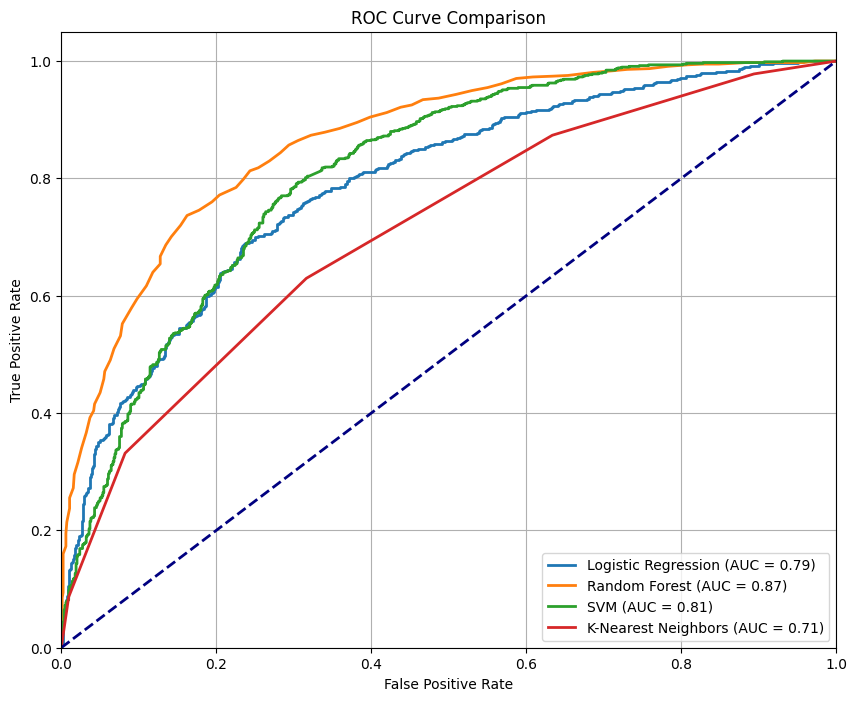


📊 Modelo: Logistic Regression
  - Teste:
    AUC: 0.79
    Accuracy: 0.68
    Precision: 0.84
    Recall: 0.40
    F1: 0.54
  - Treinamento:
    AUC: 0.81
    Accuracy: 0.69
    Precision: 0.89
    Recall: 0.80
    F1: 0.85
  🔍 Overfitting Check (F1): ⚠️ Indício de Overfitting

📊 Modelo: Random Forest
  - Teste:
    AUC: 0.87
    Accuracy: 0.78
    Precision: 0.78
    Recall: 0.77
    F1: 0.77
  - Treinamento:
    AUC: 1.00
    Accuracy: 1.00
    Precision: 0.89
    Recall: 0.80
    F1: 0.85
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: SVM
  - Teste:
    AUC: 0.81
    Accuracy: 0.74
    Precision: 0.69
    Recall: 0.81
    F1: 0.75
  - Treinamento:
    AUC: 0.83
    Accuracy: 0.74
    Precision: 0.89
    Recall: 0.80
    F1: 0.85
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: K-Nearest Neighbors
  - Teste:
    AUC: 0.71
    Accuracy: 0.66
    Precision: 0.65
    Recall: 0.63
    F1: 0.64
  - Treinamento:
    AUC: 0.88
    Acc

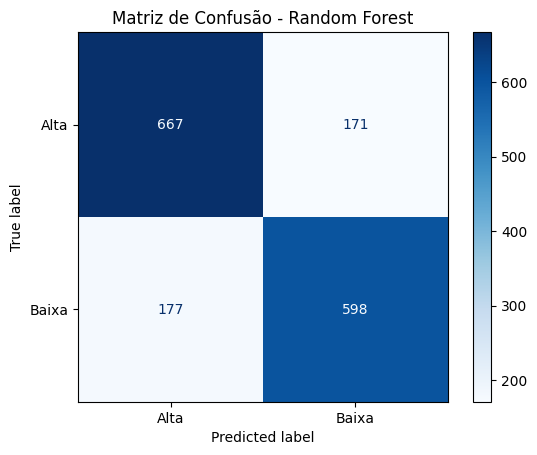

In [108]:
#Definindo os Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
#Criando um Dicionario para os scores
roc_auc_scores2 = {}
accuracy_scores2 = {}
precision_scores2 = {}
recall_scores2 = {}
f1_scores2 = {}

# Dicionários para guardar scores
metrics_train2 = {}
metrics_test2 = {}

#Plotando a Curva
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(x_train2, y_train2)

    # ---- TESTE ----
    y_probs_test2 = model.predict_proba(x_test2)[:, 1]
    y_pred_test2 = (y_probs_test2 >= 0.5).astype(int)

    test_metrics = {
        'AUC': roc_auc_score(y_test2, y_probs_test2),
        'Accuracy': accuracy_score(y_test2, y_pred_test2),
        'Precision': precision_score(y_test2, y_pred_test2),
        'Recall': recall_score(y_test2, y_pred_test2),
        'F1': f1_score(y_test2, y_pred_test2)
    }

    # ---- TREINAMENTO ----
    y_probs_train2 = model.predict_proba(x_train2)[:, 1]
    y_pred_train2 = (y_probs_train2 >= 0.5).astype(int)

    train_metrics = {
        'AUC': roc_auc_score(y_train2, y_probs_train2),
        'Accuracy': accuracy_score(y_train2, y_pred_train2),
        'Precision': precision_score(y_train2, y_train_pred2),
        'Recall': recall_score(y_train2, y_train_pred2),
        'F1': f1_score(y_train2, y_train_pred2)
    }

    # Salvando métricas
    metrics_test2[name] = test_metrics
    metrics_train2[name] = train_metrics

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test2, y_probs_test2)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {test_metrics["AUC"]:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Impressão de métricas
for name in models.keys():
    print(f"\n📊 Modelo: {name}")
    print("  - Teste:")
    for k, v in metrics_test2[name].items():
        print(f"    {k}: {v:.2f}")
    print("  - Treinamento:")
    for k, v in metrics_train2[name].items():
        print(f"    {k}: {v:.2f}")
    print("  🔍 Overfitting Check (F1):", end=" ")
    train_f1 = metrics_train2[name]['F1']
    test_f1 = metrics_test2[name]['F1']
    if train_f1 - test_f1 > 0.10:
        print("⚠️ Indício de Overfitting")
    else:
        print("✅ Sem evidência forte de overfitting")

# Matriz de confusão do melhor modelo em termos de F1 Score no teste
best_model_name2 = max(metrics_test2, key=lambda m: metrics_test2[m]['F1'])
print(f"\n🏆 Melhor modelo com base no F1 Score de teste: {best_model_name2}")

# Reajuste para obter a matriz de confusão
best_model2 = models[best_model_name2]
y_probs_best2 = best_model2.predict_proba(x_test2)[:, 1]
y_pred_best2 = (y_probs_best2 >= 0.5).astype(int)

# Matriz de Confusão
cm = confusion_matrix(y_test2, y_pred_best2)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão - {best_model_name2}")
plt.show()

# Utilizando as "features", podemos observar que o modelo performou um pouco pior do que com as variáveis originais. Nessa modalidade, o modelo de Árvore de Decisão (RF) teve melhor acurácia, mas ainda inferior ao primeiro modelo de Regressão Logística.

# Validação cruzada: Melhor Modelo

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [110]:
kFold = KFold(n_splits=5, shuffle=True, random_state=42)
result = cross_val_score(best_model2, x_train2, y_train2, cv=kFold, scoring='f1')
print("K-Fold R2 Scores: {0}".format(result))
print("K-Fold R2 Mean: {0}".format(result.mean()))

K-Fold R2 Scores: [0.7442623  0.74565561 0.74503817 0.72101449 0.78288431]
K-Fold R2 Mean: 0.7477709749214876


## Podemos observar que após a validação cruzada do melhor modelo com as "features" selecionadas, o modelo apresentou uma acurácia média de aproximadamente 75% (setenta e cinco por cento), o que atende os parâmetors do nosso desafio.

In [111]:
from sklearn.model_selection import GridSearchCV #metodo para seleção dos melhores Ks (#Basicamente a busca por força bruta)
from sklearn.metrics import make_scorer, accuracy_score, f1_score #métricas de validação
import numpy as np
import matplotlib.pyplot as pltd

In [113]:
error = [] #armazenar os erros

# Calculating error for K values between 1 and 15
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train2, y_train2) # Changed x_train to x_train2 and y_train to y_train2
    pred_i = knn.predict(x_test2) # Changed x_test to x_test2
    error.append(np.mean(pred_i != y_test2)) # Changed y_test to y_test2

Text(0, 0.5, 'Mean Error')

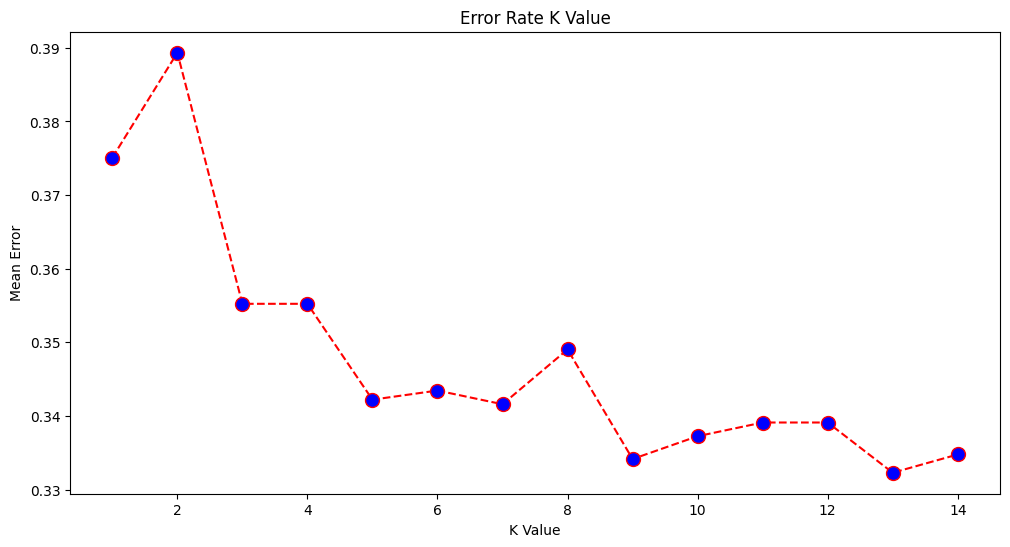

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [120]:
# Buscar os melhores parâmetros
# Vamos usar uma técnica chamada Gridsearch que é basicamente a busca por força bruta
# Iremos utilizar a técnica de validação cruzada de 5 folds (divisões) em cima do conjunto de treinamento
# Como métrica de melhor desemepnho usaremos a acurácia, isto é, estamos buscando os hiperparâmetros que maximizam a acurácia

# Parâmetros testados
param_grid = {'n_neighbors':[9,13], #total de vizinhos
              'weights': ['uniform', 'distance'], #Função de peso usada na previsão
              'metric':['cosine', 'euclidean', 'manhattan'] #métrica para cálculo da distância
             }

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) #cv = gerador de validação cruzada / n_jobs = determina a quantidade de jobs processados

grid.fit(x_train2, y_train2) #Selecionando os melhores hiperparametros com base nos dados de treino
knn_params = grid.best_params_
print('KNN', knn_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN {'metric': 'cosine', 'n_neighbors': 13, 'weights': 'distance'}


In [123]:
def AplicaValidacaoCruzada(x_axis, y_axis):
  # Linear Models.
  from sklearn.neighbors import KNeighborsClassifier  # k-vizinhos mais próximos (KNN)
  from sklearn.ensemble import RandomForestClassifier # RandomForest
  from sklearn.svm import SVC                         # Maquina de Vetor Suporte SVM

  # Cross-Validation models.
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import KFold

  # Configuração de KFold.
  kfold  = KFold(n_splits=10, shuffle=True)

  # Axis
  x = x_axis
  y = y_axis

  # Criando os modelos

  # KNN
  knn = KNeighborsClassifier(n_neighbors=8, metric= 'euclidean', weights='distance')
  knn.fit(x_train2, y_train2)

  # SVM
  svm = SVC()
  svm.fit(x_train2, y_train2)

  # RandomForest
  rf = RandomForestClassifier(random_state=7)
  rf.fit(x_train2, y_train2)

  # Applyes KFold to models.
  knn_result = cross_val_score(knn, x, y, cv = kfold)
  svm_result = cross_val_score(svm, x, y, cv = kfold)
  rf_result = cross_val_score(rf, x, y, cv = kfold)

  # Creates a dictionary to store Linear Models.
  dic_models = {
    "KNN": knn_result.mean(),
    "SVM": svm_result.mean(),
    "RF": rf_result.mean()
  }
  # Select the best model.
  melhorModelo = max(dic_models, key=dic_models.get)

  print("KNN (R^2): {0}\nSVM (R^2): {1}\nRandom Forest (R^2): {2}".format(knn_result.mean(), svm_result.mean(), rf_result.mean()))
  print("O melhor modelo é : {0} com o valor: {1}".format(melhorModelo, dic_models[melhorModelo]))

In [124]:
  AplicaValidacaoCruzada(x, y)

KNN (R^2): 0.9067249103942652
SVM (R^2): 0.5818731671554251
Random Forest (R^2): 0.8796741609644835
O melhor modelo é : KNN com o valor: 0.9067249103942652


## Após a validação cruzada, o modelo que melhor performou foi o KNN.